# Hierarchical Bayesian Neural Networks

Illustration of hierarchial Bayesian neural network classifiers.
Code and text is based on [This blog post](https://twiecki.io/blog/2018/08/13/hierarchical_bayesian_neural_network/) by Thomas Wiecki.
[Original PyMC3 Notebook](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/bayesian_neural_network_hierarchical.ipynb). Converted to Numpyro by Aleyna Kara (@karalleyna).


## Setup

Please change your colab runtime to CPU.

In [1]:
# http://num.pyro.ai/en/stable/getting_started.html#installation
!pip install numpyro[cuda111] -f https://storage.googleapis.com/jax-releases/jax_releases.html


Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [2]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt

from jax import vmap, jit
import jax.numpy as jnp
from jax.random import PRNGKey, split, normal
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

from scipy import stats
import seaborn as sns
from warnings import filterwarnings

import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

from functools import partial

filterwarnings('ignore')
sns.set_style('white')

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

## Data

The data set we are using are our battle tested half-moons as it is simple, non-linear and leads to pretty visualizations. This is what it looks like:

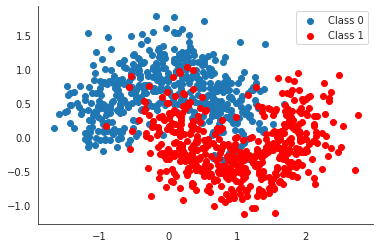

In [3]:
X, Y = make_moons(noise=0.3, n_samples=1000)
plt.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); plt.legend();

This is just to illustrate what the data generating distribution looks like, we will use way fewer data points, and create different subsets with different rotations.

In [4]:
def rotate(X, deg):
    theta = jnp.radians(deg)
    c, s = jnp.cos(theta), jnp.sin(theta)
    R = jnp.array([[c, -s], [s, c]])
    X = X @ R
    return X

In [5]:
#@title Set the number of groups

n_grps = 18 #@param {type:"slider", min:0, max:20, step:1}


In [6]:
n_samples = 100
n_grps_sq = int(jnp.sqrt(n_grps))

def generate_data(X, key):
  X, Y = make_moons(noise=0.3, n_samples=n_samples)
  X = scale(jnp.array(X))
  
  # Rotate the points randomly for each category
  rotate_by = normal(key) * 90.
  X = rotate(X, rotate_by)
  return X, Y

In [7]:
key = PRNGKey(0)
keys = split(key, n_grps)

In [8]:
Xs, Ys = vmap(generate_data, in_axes=(None, 0))(X, keys)

In [9]:
Xs_train = Xs[:, :n_samples // 2, :]
Xs_test = Xs[:, n_samples // 2:, :]

In [10]:
Ys_train = Ys[:, :n_samples // 2]
Ys_test = Ys[:, n_samples // 2:]

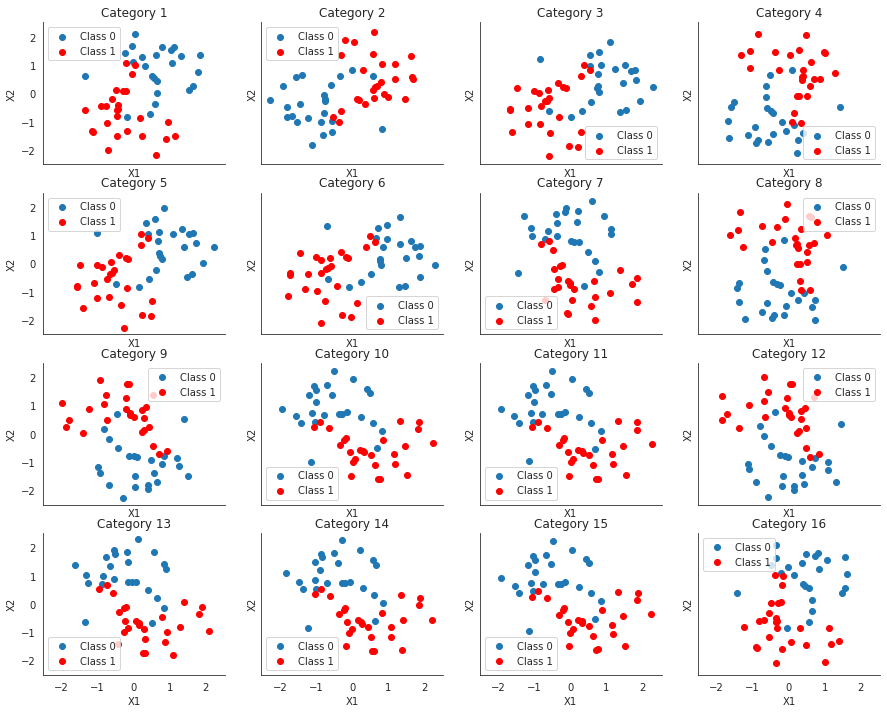

In [11]:
fig, axs = plt.subplots(figsize=(15, 12), nrows=n_grps_sq, ncols=n_grps_sq, 
                        sharex=True, sharey=True)
axs = axs.flatten()
for i, (X, Y, ax) in enumerate(zip(Xs_train, Ys_train, axs)):
    ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
    ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
    sns.despine(); ax.legend()
    ax.set(title='Category {}'.format(i + 1), xlabel='X1', ylabel='X2')

As you can see, we have 4 categories in default that share a higher-order structure (the half-moons). However, in the pure data space, no single classifier will be able to do a good job here. Also, because we only have 50 data points in each class, a NN will likely have a hard time producing robust results. But let's actually test this.

## Fit separate MLPs, one per task

First we fit one MLP per task/dataset. For details, see Thomas's blob post 
 on [Bayesian Deep Learning](https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/).

In [12]:
'''
A two-layer bayesian neural network with computational flow
given by D_X => D_H => D_H => D_Y where D_H is the number of
hidden units.
'''
def bnn(X, Y, layer_sizes):
    D_X, D_Y = X.shape[1], 1
    
    z = X
    for i, (D_in, D_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
      w = numpyro.sample(f"w{i}", dist.Normal(jnp.zeros((D_in, D_out)), jnp.ones((D_in, D_out))))  # D_X D_H
      z = jnp.tanh(jnp.matmul(z, w))   # N D_H  <= first layer of activations

    # sample final layer of weights and neural network output
    w_final = numpyro.sample(f"w_final", dist.Normal(jnp.zeros((D_out, D_Y)), jnp.ones((D_out, D_Y))))  # D_H D_Y
    z_final = jnp.matmul(z, w_final).squeeze(-1) # N D_Y  <= output of the neural network

    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z_final), obs=Y)

In [13]:
def run_inference(model, rng_key, num_warmup=100, num_samples=100, num_chains=1, **kwargs):
  kernel = NUTS(model)
  mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains, progress_bar=False)
  mcmc.run(rng_key, **kwargs)
  return mcmc

In [14]:
def get_predictions(model, rng_key, samples, X, layer_sizes, num_warmup=100, num_samples=100, num_chains=1, **bnn_kwargs):
  # helper function for prediction
  @jit
  def predict(samples, rng_key):
      model_ = handlers.substitute(handlers.seed(model, rng_key), samples)
      # note that Y will be sampled in the model because we pass Y=None here
      model_trace = handlers.trace(model_).get_trace(X=X, Y=None, layer_sizes=layer_sizes, **bnn_kwargs) if bnn_kwargs else handlers.trace(model_).get_trace(X=X, Y=None, layer_sizes=layer_sizes)
      return model_trace['Y']['value']

  # predict Y at inputs X
  keys = random.split(rng_key, num_samples*num_chains)
  predictions = vmap(predict, in_axes=(0, 0))(samples,keys)
  return predictions

In [15]:
def get_mean_predictions(predictions, threshold=0.5):
  # compute mean prediction and confidence interval around median
  mean_prediction = jnp.mean(predictions, axis=0)
  return mean_prediction > threshold

In [16]:
def fit_and_eval(model, training_data, test_data, grid, layer_sizes, num_warmup=100, num_samples=100, num_chains=1,  **bnn_kwargs):
  X_train, Y_train = training_data
  X_test, Y_test = test_data
  
  args = [num_warmup, num_samples, num_chains]

  kwargs = {"X": X_train, "Y": Y_train, "layer_sizes":layer_sizes}
  if bnn_kwargs:
    kwargs = {**kwargs, **bnn_kwargs}

  # do inference
  rng_key, rng_key_train, rng_key_test, rng_key_grid = random.split(random.PRNGKey(0), 4)
  mcmc = run_inference(model, rng_key, *args, **kwargs)
  samples = mcmc.get_samples()
  
  # predict Y_train and Y_test at inputs X_traind and X_test, respectively
  predictions = get_predictions(model, rng_key_train, samples, X_train, layer_sizes, *args, **bnn_kwargs)
  pred_train = get_mean_predictions(predictions)
  
  predictions = get_predictions(model, rng_key_test, samples, X_test, layer_sizes, *args, **bnn_kwargs)
  pred_test = get_mean_predictions(predictions)

  ppc_grid = get_predictions(model, rng_key_grid, samples, grid, layer_sizes, *args, **bnn_kwargs)
  return pred_train, pred_test, ppc_grid, samples

In [17]:
num_samples=500
num_chains=1
num_warmup=1000

grid = jnp.mgrid[-3:3:100j, -3:3:100j].reshape((2, -1)).T

hidden_layers = [5, 5]

In [18]:
fit_eval = lambda train, test: fit_and_eval(bnn, train, test, grid, (train[0].shape[1], *hidden_layers), num_warmup, num_samples, num_chains)
Ys_pred_train, Ys_pred_test, ppc_grid_single, _ = vmap(fit_eval)((Xs_train,Ys_train), (Xs_test, Ys_test))

In [19]:
print ("Train accuracy = {:.2f}%".format(100*jnp.mean(Ys_pred_train == Ys_train)))

Train accuracy = 88.00%


In [20]:
print ("Test accuracy = {:.2f}%".format(100*jnp.mean(Ys_pred_test == Ys_test)))

Test accuracy = 80.67%


OK, that doesn't seem so bad. Now let's look at the decision surfaces -- i.e. what the classifier thinks about each point in the data space.

In [21]:
def plot_decision_surfaces_non_hierarchical(nrows=2, ncols=2):
  fig, axes = plt.subplots(figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True)
  axes = axes.flatten()
  for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_pred_train, Ys_train, axes)):
      contour = ax.contourf(grid[:, 0].reshape(100, 100), grid[:, 1].reshape(100, 100), ppc_grid_single[i, ...].mean(axis=0).reshape(100, 100), cmap=cmap)
      ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
      ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
      sns.despine(); ax.legend()

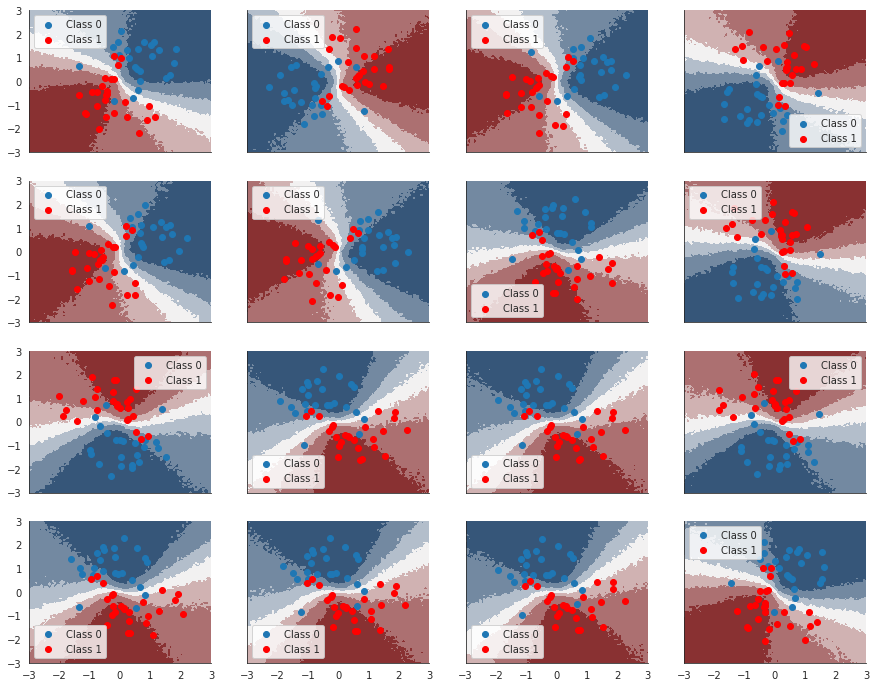

In [22]:
plot_decision_surfaces_non_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

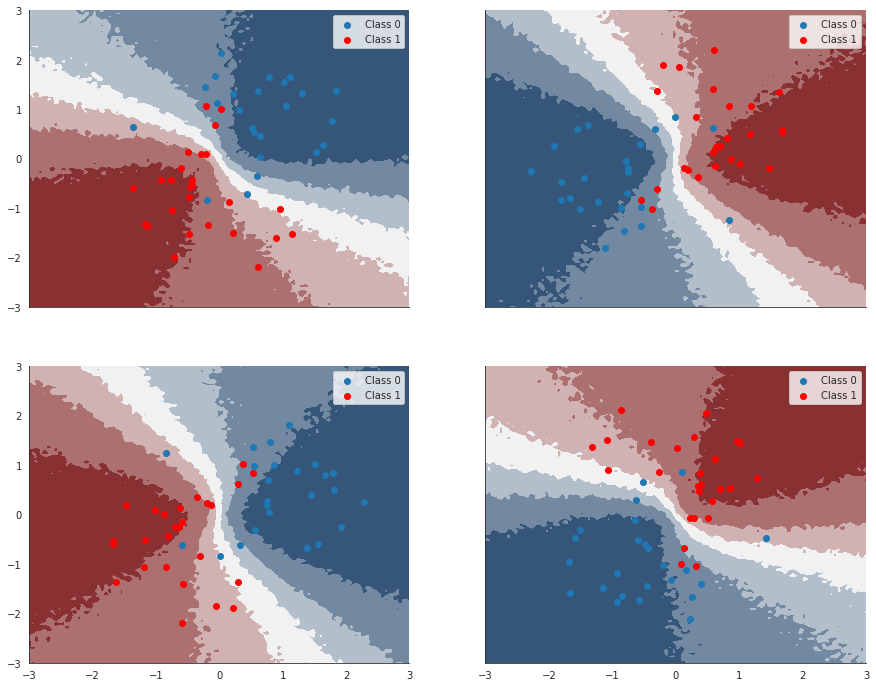

In [23]:
plot_decision_surfaces_non_hierarchical()

That doens't look all that convincing. We know from the data generation process we should get  a "Z"-shaped decision surface, but we don't have enough data to properly estimate the non-linearity in every category.

## Hierarchical Bayesian Neural Network


It's actually quite straight-forward to turn this into one big hierarchical model for all categories, rather than many individual ones. Let's call the weight connecting neuron $i$ in layer 1 to neuron $j$ in layer 2 in category $c$ $w_{i, j, c}$ (I just omit the layer index for simplicity in notation). Rather than placing a fixed prior as we did above (i.e. $ w_{i, j, c} \sim \mathcal{N}(0, 1^2)$), we will assume that each weight comes from an overarching group distribution:
$ w_{i, j, c} \sim \mathcal{N}(\mu_{i, j}, \sigma^2)$. The key is that we will estimate $\mu_{i, j}$ and $\sigma$ simultaneously from data. 


Why not allow for different $\sigma_{i,j}^2$ per connection you might ask? Mainly just to make our life simpler and because it works well enough.

Note that we create a very rich model here. Every individual weight has its own hierarchical structure with a single group mean parameter and 16 per-category weights distributed around the group mean. While this creates a big amount of group distributions (as many as the flat NN had weights) there is no problem with this per-se, although it might be a bit unusual. One might argue that this model is quite complex and while that's true, in terms of degrees-of-freedom, this model is simpler than the unpooled one above (more on this below).

As for the code, we stack weights along a 3rd dimenson to get separate weights for each group. That way, through the power of broadcasting, the linear algebra works out almost the same as before.

In [24]:
def hierarchical_bnn(X, Y, layer_sizes):
    D_C, _, D_X = X.shape
    D_Y = 1
    layer_sizes =(D_X, *layer_sizes, D_Y)
    z = X
    
    w_mean, w_std = [], []
    for i, (D_in, D_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        # Group mean distribution for input to hidden layer
        w_c = numpyro.sample(f"w{i}_c", dist.Normal(jnp.zeros((D_in, D_out)), jnp.ones((D_in, D_out))))  
        # Group standard-deviation
        w_c_std = numpyro.sample(f"w{i}_c_std", dist.HalfNormal(1.))
        
        w_mean.append(w_c)
        w_std.append(w_c_std)
    
    with numpyro.plate("plate_i", D_C, dim=-3):
      for k, (D_in, D_out, w_c, w_c_std) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:], w_mean, w_std)):        
        w_all = numpyro.sample(f"w{k}_all", dist.Normal(jnp.zeros((1, D_in, D_out)), jnp.ones((1, D_in, D_out))))
        w = w_all * w_c_std + w_c
        z = jnp.tanh(jnp.matmul(z, w)) if k!= len(layer_sizes) - 2 else jnp.matmul(z, w) # output of the neural network
    
    z = z.squeeze(-1)
    # Bernoulli likelihood <= Binary classification
    Y = numpyro.sample("Y", dist.Bernoulli(logits=z), obs=Y)

In [25]:
grid_3d = jnp.repeat(grid[None, ...], n_grps, axis=0)

In [26]:
Ys_hierarchical_pred_train, Ys_hierarchical_pred_test, ppc_grid, trace_hier = fit_and_eval(hierarchical_bnn, (Xs_train,Ys_train), (Xs_test, Ys_test), grid_3d, (Xs_train.shape[-1], *hidden_layers), num_warmup, num_samples, num_chains)

In [27]:
print('Train accuracy = {:.2f}%'.format(100 * jnp.mean(Ys_hierarchical_pred_train == Ys_train)))

Train accuracy = 93.00%


In [28]:
print('Test accuracy = {:.2f}%'.format(100 * jnp.mean(Ys_hierarchical_pred_test == Ys_test)))

Test accuracy = 95.89%


Great -- we get higher train *and* test accuracy. Let's look at what the classifier has learned for each category.

In [29]:
def plot_decision_surfaces_hierarchical(nrows=2, ncols=2):
  fig, axes = plt.subplots(figsize=(15, 12), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

  for i, (X, Y_pred, Y_true, ax) in enumerate(zip(Xs_train, Ys_hierarchical_pred_train, Ys_train, axes.flatten())):
      contour = ax.contourf(grid[:, 0].reshape((100, 100)), grid[:, 1].reshape((100, 100)), ppc_grid[:, i, :].mean(axis=0).reshape(100, 100), cmap=cmap)
      ax.scatter(X[Y_true == 0, 0], X[Y_true == 0, 1], label='Class 0')
      ax.scatter(X[Y_true == 1, 0], X[Y_true == 1, 1], color='r', label='Class 1')
      sns.despine(); ax.legend()

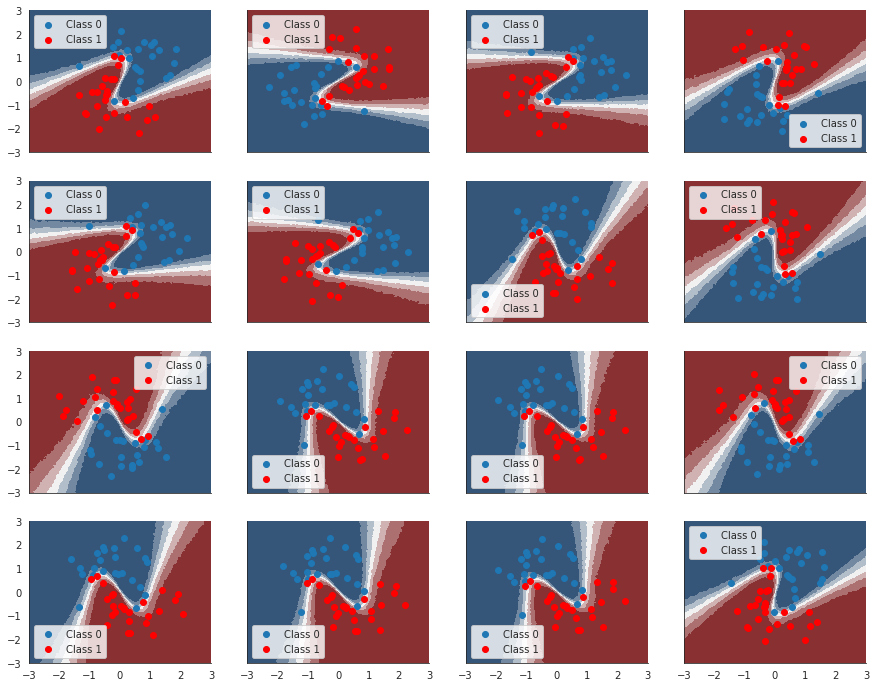

In [30]:
plot_decision_surfaces_hierarchical(nrows=n_grps_sq, ncols=n_grps_sq)

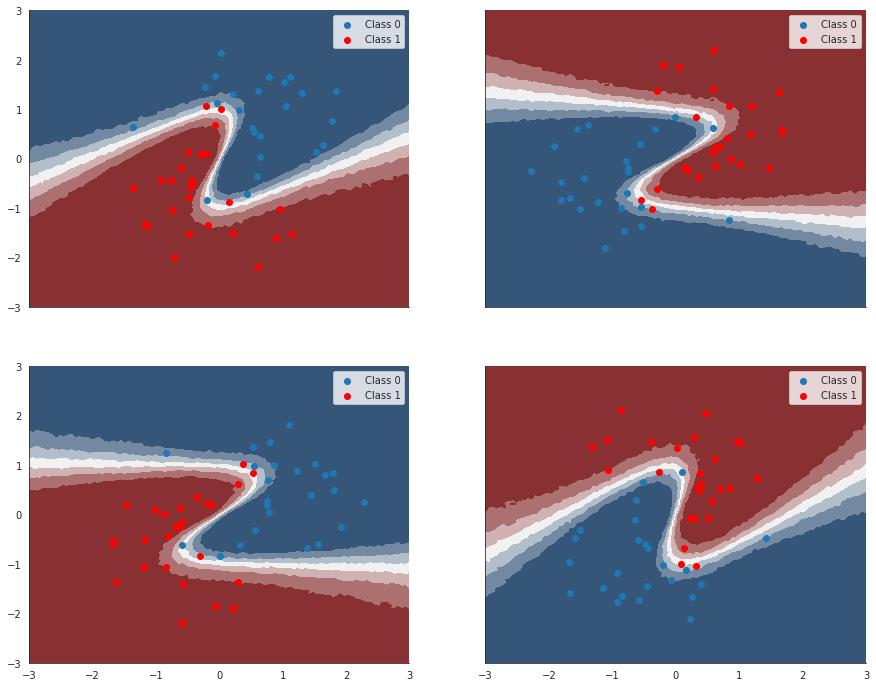

In [31]:
plot_decision_surfaces_hierarchical()